In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import os
import time
import copy

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cd /content/drive/"My Drive"/"Colab Notebooks"/data/train && ls

C  fist  L  okay  palm	peace


In [0]:
data_dir = "/content/drive/My Drive/Colab Notebooks/data"
TRAIN = 'train'
TEST = 'test'

In [0]:
# VGG-16 takes 244x244 input, so we ned to resize our images
transformation = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.ToTensor(),
    ])

In [0]:
image_datasets = {
    i: datasets.ImageFolder(os.path.join(data_dir, i),
                            transform = transformation
                            )
                for i in [TRAIN, TEST]
                }

In [0]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 2656
    Root Location: /content/drive/My Drive/Colab Notebooks/data/train
    Transforms (if any): Compose(
                             Resize(size=244, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [0]:
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaded 2656 images under train
Loaded 300 images under test
Classes: 
['C', 'L', 'fist', 'okay', 'palm', 'peace']


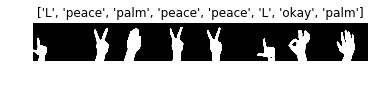

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

            
        print('{} Loss: {:.8f} Acc: {:.8f}'.format(phase, running_loss, epoch_acc))
            
        if phase == 'test' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy. deepcopy(model.state_dict())
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.8f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model
            

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(node=was_training)
                

In [0]:
num_classes = 6
model_ft = models.vgg16(pretrained=True)
model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:20, 26534437.97it/s]


In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
test Loss: 550.84216976 Acc: 0.16666667

Epoch 1/24
----------
test Loss: 550.84217024 Acc: 0.16666667

Epoch 2/24
----------
test Loss: 550.84217310 Acc: 0.16666667

Epoch 3/24
----------
test Loss: 550.84216785 Acc: 0.16666667

Epoch 4/24
----------
test Loss: 550.84216833 Acc: 0.16666667

Epoch 5/24
----------
test Loss: 550.84217072 Acc: 0.16666667

Epoch 6/24
----------
test Loss: 550.84216881 Acc: 0.16666667

Epoch 7/24
----------
test Loss: 550.84217072 Acc: 0.16666667

Epoch 8/24
----------
test Loss: 550.84217072 Acc: 0.16666667

Epoch 9/24
----------
test Loss: 550.84216785 Acc: 0.16666667

Epoch 10/24
----------
test Loss: 550.84216881 Acc: 0.16666667

Epoch 11/24
----------
test Loss: 550.84216690 Acc: 0.16666667

Epoch 12/24
----------
test Loss: 550.84216404 Acc: 0.16666667

Epoch 13/24
----------
test Loss: 550.84216547 Acc: 0.16666667

Epoch 14/24
----------
test Loss: 550.84216881 Acc: 0.16666667

Epoch 15/24
----------
test Loss: 550.84217167 Acc

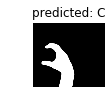

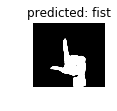

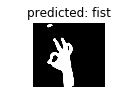

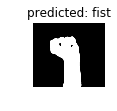

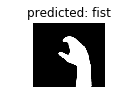

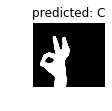

In [0]:
visualize_model(model_ft)